In [3]:
import pandas as pd

# Load the CSV file
file_path = "AWT vs. NPS v4.csv"  # Update with your file path
data = pd.read_csv(file_path)

# Standardize column names (strip whitespace)
data.columns = data.columns.str.strip()

# Check for the 'NET_PROMOTER_SCORE' column
if 'NET_PROMOTER_SCORE' not in data.columns:
    print("Error: 'NET_PROMOTER_SCORE' column not found. Available columns:", data.columns.tolist())
else:
    # Debugging: Display unique values and data type of 'NET_PROMOTER_SCORE'
    print("NET_PROMOTER_SCORE data type before cleaning:", data['NET_PROMOTER_SCORE'].dtype)
    print("Unique values before cleaning:", data['NET_PROMOTER_SCORE'].unique())

    # Convert NET_PROMOTER_SCORE to numeric, handling errors
    data['NET_PROMOTER_SCORE'] = pd.to_numeric(data['NET_PROMOTER_SCORE'], errors='coerce')

    # Drop rows where NET_PROMOTER_SCORE could not be converted
    data = data.dropna(subset=['NET_PROMOTER_SCORE'])
    print("NET_PROMOTER_SCORE data type after cleaning:", data['NET_PROMOTER_SCORE'].dtype)
    print("Unique values after cleaning:", data['NET_PROMOTER_SCORE'].unique())

    # Convert WAIT_TIME from seconds to minutes
    data['WAIT_TIME_MINUTES'] = data['WAIT_TIME'] / 60

    # Combine CREATED_DATE and CREATED_TIME into a single datetime column
    data['CREATED_AT'] = pd.to_datetime(data['CREATED_DATE'] + ' ' + data['CREATED_TIME'])

    # Extract DATE and HOUR for later calculations
    data['DATE'] = data['CREATED_AT'].dt.date
    data['HOUR'] = data['CREATED_AT'].dt.hour

    # Function to calculate NPS for each group of data
    def calculate_nps_for_hour(hour_data):
        total_responses = len(hour_data)
        if total_responses == 0:  # Avoid division by zero
            return 0
        promoters = len(hour_data[hour_data['NET_PROMOTER_SCORE'] >= 9])  # Promoters: NPS of 9-10
        detractors = len(hour_data[hour_data['NET_PROMOTER_SCORE'] <= 6])  # Detractors: NPS of 0-6
        nps = ((promoters - detractors) / total_responses) * 100
        return nps

    # List to store results
    results = []

    # Iterate through each unique (DATE, HOUR) combination
    for (date, hour), hour_data in data.groupby(['DATE', 'HOUR']):
        avg_wait_time = hour_data['WAIT_TIME_MINUTES'].mean()
        nps_score = calculate_nps_for_hour(hour_data)
        
        # Append the results for each group (DATE, HOUR)
        results.append({
            'DATE': date,
            'HOUR': hour,
            'AVG_WAIT_TIME_MINUTES': avg_wait_time,
            'NPS_SCORE': nps_score
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save the results to a CSV file
    output_path = "Hourly_AWT_NPS.csv"  # Update with your desired output path
    results_df.to_csv(output_path, index=False)

    print(f"Results saved to {output_path}")


NET_PROMOTER_SCORE data type before cleaning: int64
Unique values before cleaning: [10  9  8  1  3  7  5  2  6  0  4]
NET_PROMOTER_SCORE data type after cleaning: int64
Unique values after cleaning: [10  9  8  1  3  7  5  2  6  0  4]
Results saved to Hourly_AWT_NPS.csv


         DATE  HOUR  AVG_WAIT_TIME_MINUTES  NPS_SCORE
0  2024-01-01     0               0.352564      100.0
1  2024-01-01     1               3.925000       90.0
2  2024-01-01     2               0.131250       62.5
3  2024-01-01     3               0.189394      100.0
4  2024-01-01     4               0.983333      100.0


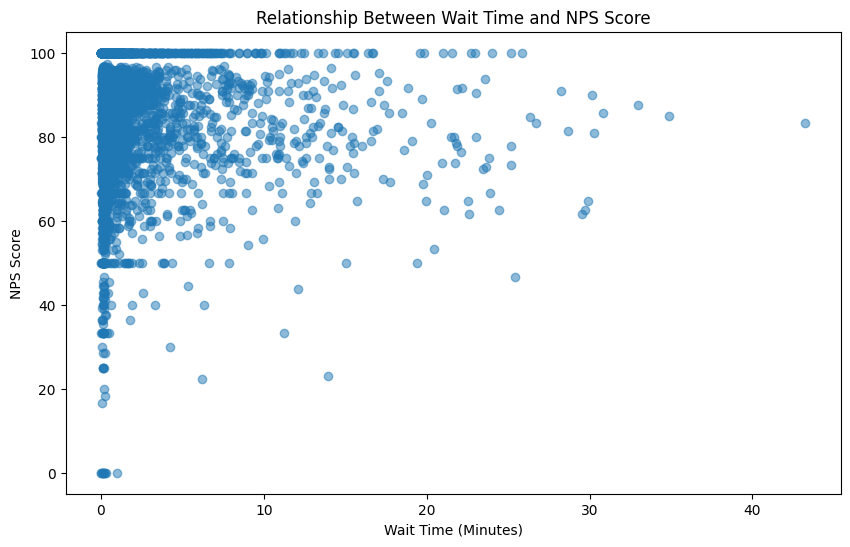

Pearson Correlation Coefficient: -0.09
P-value: 0.0000


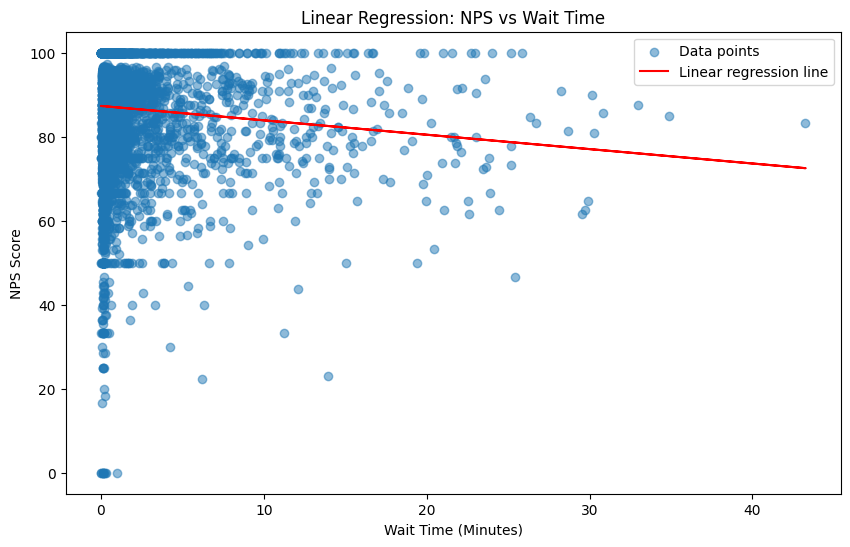

Wait time when NPS drops below 82 (Linear Regression): 15.56 minutes


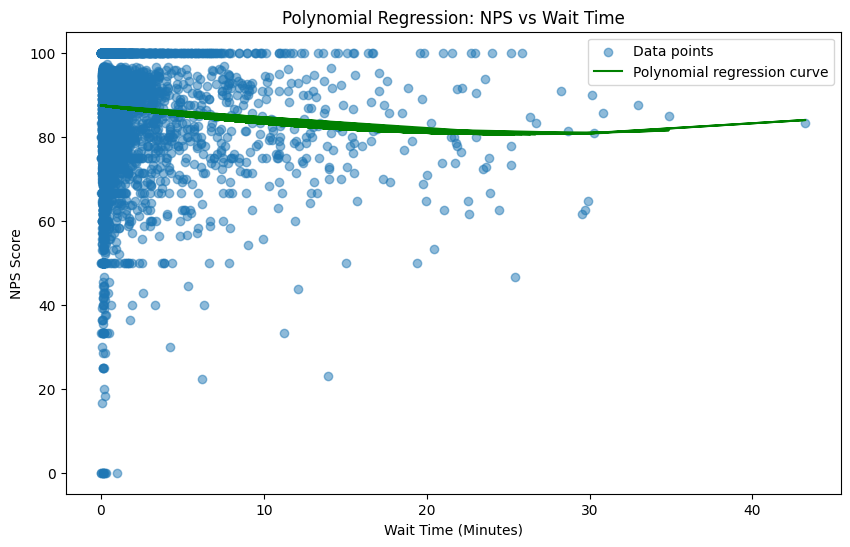

Wait time when NPS drops below 82 (Polynomial Regression): 13.88 minutes


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Load the data
file_path = "Hourly_AWT_NPS.csv"  # Update with the path to your file
data = pd.read_csv(file_path)

# Check the first few rows to ensure correct data loading
print(data.head())

# Plotting the relationship between wait time and NPS
plt.figure(figsize=(10, 6))
plt.scatter(data['AVG_WAIT_TIME_MINUTES'], data['NPS_SCORE'], label='Data points', alpha=0.5)
plt.xlabel('Wait Time (Minutes)')
plt.ylabel('NPS Score')
plt.title('Relationship Between Wait Time and NPS Score')
plt.show()

# 1. **Correlation Analysis**: Calculate Pearson correlation coefficient
correlation, p_value = stats.pearsonr(data['AVG_WAIT_TIME_MINUTES'], data['NPS_SCORE'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

# If the p-value is low (<0.05), the correlation is statistically significant

# 2. **Linear Regression**: Fit a linear regression model
X = data['AVG_WAIT_TIME_MINUTES'].values.reshape(-1, 1)
y = data['NPS_SCORE']

linear_model = LinearRegression()
linear_model.fit(X, y)

# Predict NPS using the linear regression model
y_pred = linear_model.predict(X)

# Plotting the regression line on the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['AVG_WAIT_TIME_MINUTES'], data['NPS_SCORE'], label='Data points', alpha=0.5)
plt.plot(data['AVG_WAIT_TIME_MINUTES'], y_pred, color='red', label='Linear regression line')
plt.xlabel('Wait Time (Minutes)')
plt.ylabel('NPS Score')
plt.title('Linear Regression: NPS vs Wait Time')
plt.legend()
plt.show()

# Calculate the wait time when NPS drops below 82 using the linear model
wait_time_for_nps_82 = (82 - linear_model.intercept_) / linear_model.coef_[0]
print(f"Wait time when NPS drops below 82 (Linear Regression): {wait_time_for_nps_82:.2f} minutes")

# 3. **Polynomial Regression (2nd degree)**: Fit a polynomial regression model to capture non-linear relationships
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Predict NPS using the polynomial regression model
y_poly_pred = poly_model.predict(X_poly)

# Plotting the polynomial regression curve
plt.figure(figsize=(10, 6))
plt.scatter(data['AVG_WAIT_TIME_MINUTES'], data['NPS_SCORE'], label='Data points', alpha=0.5)
plt.plot(data['AVG_WAIT_TIME_MINUTES'], y_poly_pred, color='green', label='Polynomial regression curve')
plt.xlabel('Wait Time (Minutes)')
plt.ylabel('NPS Score')
plt.title('Polynomial Regression: NPS vs Wait Time')
plt.legend()
plt.show()

# Calculate the wait time when NPS drops below 82 using the polynomial model
def find_wait_time_for_nps_82_poly(model, poly_transformer, target_nps):
    # Solve for wait time when NPS equals the target value
    # Using the inverse of the polynomial transformation
    coeffs = model.coef_
    intercept = model.intercept_

    # The equation for a polynomial regression is: 
    # y = coeff[0] * x^2 + coeff[1] * x + intercept
    # We need to solve for x when y = target_nps
    
    # For simplicity, we approximate solving the quadratic equation
    a = coeffs[2]
    b = coeffs[1]
    c = intercept - target_nps

    # Solve the quadratic equation a * x^2 + b * x + c = 0
    discriminant = b**2 - 4*a*c
    if discriminant >= 0:
        # Two solutions for x
        x1 = (-b + np.sqrt(discriminant)) / (2 * a)
        x2 = (-b - np.sqrt(discriminant)) / (2 * a)
        return min(x1, x2)  # Return the smallest positive value
    else:
        return None  # No real solution

# Find the wait time for NPS = 82 using polynomial regression
wait_time_for_nps_82_poly = find_wait_time_for_nps_82_poly(poly_model, poly, 82)
print(f"Wait time when NPS drops below 82 (Polynomial Regression): {wait_time_for_nps_82_poly:.2f} minutes")


In [18]:
import pandas as pd

file_path = "Hourly_AWT_NPS.csv"
data = pd.read_csv(file_path)

print(data.head())

nps_threshold = 82
data_below_threshold = data[data['NPS_SCORE'] < nps_threshold]

average_wait_time_per_hour = data_below_threshold.groupby('HOUR')['AVG_WAIT_TIME_MINUTES'].mean()
print("Average Wait Time for Hours with NPS < 82:")
print(average_wait_time_per_hour)

average_wait_time_below_threshold = data_below_threshold['AVG_WAIT_TIME_MINUTES'].mean()
print(f"Average Wait Time for NPS < {nps_threshold}: {average_wait_time_below_threshold:.2f} minutes")

average_wait_time_all = data['AVG_WAIT_TIME_MINUTES'].mean()
print(f"Average Wait Time for the entire dataset: {average_wait_time_all:.2f} minutes")


         DATE  HOUR  AVG_WAIT_TIME_MINUTES  NPS_SCORE
0  2024-01-01     0               0.352564      100.0
1  2024-01-01     1               3.925000       90.0
2  2024-01-01     2               0.131250       62.5
3  2024-01-01     3               0.189394      100.0
4  2024-01-01     4               0.983333      100.0
Average Wait Time for Hours with NPS < 82:
HOUR
0     3.817803
1     2.978771
2     4.250132
3     4.781079
4     5.885914
10    1.053749
11    1.401340
12    1.216287
13    0.813499
14    1.161140
15    1.438328
16    1.559030
17    1.782762
18    1.596875
19    1.564038
20    0.531207
21    0.376984
22    0.850751
23    1.315263
Name: AVG_WAIT_TIME_MINUTES, dtype: float64
Average Wait Time for NPS < 82: 1.85 minutes
Average Wait Time for the entire dataset: 1.35 minutes


In [15]:
import pandas as pd

# Load the data
file_path = "Hourly_AWT_NPS.csv"  # Update with the path to your file
data = pd.read_csv(file_path)

# Check the first few rows to ensure correct data loading
print(data.head())

# Set the NPS threshold
nps_threshold = 82

# Filter the data to include only the rows where NPS is below 82
data_below_threshold = data[data['NPS_SCORE'] < nps_threshold]

# Calculate the average wait time when NPS is below 82
average_wait_time_below_threshold = data_below_threshold['AVG_WAIT_TIME_MINUTES'].mean()

# Display the result
print(f"Average Wait Time for NPS < {nps_threshold}: {average_wait_time_below_threshold:.2f} minutes")


         DATE  HOUR  AVG_WAIT_TIME_MINUTES  NPS_SCORE
0  2024-01-01     0               0.352564      100.0
1  2024-01-01     1               3.925000       90.0
2  2024-01-01     2               0.131250       62.5
3  2024-01-01     3               0.189394      100.0
4  2024-01-01     4               0.983333      100.0
Average Wait Time for NPS < 82: 1.85 minutes


In [16]:
import pandas as pd

# Load the data
file_path = "Hourly_AWT_NPS.csv"  # Update with the path to your file
data = pd.read_csv(file_path)

# Check the first few rows to ensure correct data loading
print(data.head())

# Calculate the average wait time for the entire dataset
average_wait_time_all = data['AVG_WAIT_TIME_MINUTES'].mean()

# Display the result
print(f"Average Wait Time for the entire dataset: {average_wait_time_all:.2f} minutes")


         DATE  HOUR  AVG_WAIT_TIME_MINUTES  NPS_SCORE
0  2024-01-01     0               0.352564      100.0
1  2024-01-01     1               3.925000       90.0
2  2024-01-01     2               0.131250       62.5
3  2024-01-01     3               0.189394      100.0
4  2024-01-01     4               0.983333      100.0
Average Wait Time for the entire dataset: 1.35 minutes


In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the data
file_path = "Hourly_AWT_NPS.csv"  # Update with the path to your file
data = pd.read_csv(file_path)

# Check the first few rows to ensure correct data loading
print(data.head())

# Initialize a list to store the results
results = []

# Perform regression for each hour of the day (0-23)
for hour in range(24):
    # Filter data for the current hour
    hour_data = data[data['HOUR'] == hour]
    
    # Check if we have data for this hour
    if len(hour_data) > 1:
        # Prepare the data for regression
        X = hour_data[['AVG_WAIT_TIME_MINUTES']].values.reshape(-1, 1)  # Independent variable (wait time)
        y = hour_data['NPS_SCORE']  # Dependent variable (NPS score)
        
        # Initialize the regression model
        model = LinearRegression()
        
        # Fit the model
        model.fit(X, y)
        
        # Get the regression coefficients
        slope = model.coef_[0]
        intercept = model.intercept_
        r_squared = model.score(X, y)
        
        # Store the results for this hour
        results.append({
            'HOUR': hour,
            'SLOPE': slope,
            'INTERCEPT': intercept,
            'R_SQUARED': r_squared
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Export the results to a CSV file
output_file_path = "Hourly_Regression_Results.csv"  # Update with your desired output file path
results_df.to_csv(output_file_path, index=False)

# Confirm that the file was saved
print(f"Regression results have been saved to {output_file_path}")


         DATE  HOUR  AVG_WAIT_TIME_MINUTES  NPS_SCORE
0  2024-01-01     0               0.352564      100.0
1  2024-01-01     1               3.925000       90.0
2  2024-01-01     2               0.131250       62.5
3  2024-01-01     3               0.189394      100.0
4  2024-01-01     4               0.983333      100.0
Regression results have been saved to Hourly_Regression_Results.csv


In [21]:
import pandas as pd

# Load the data
file_path = "Hourly_AWT_NPS.csv"  # Update with the path to your file
data = pd.read_csv(file_path)

# Print first few rows of the data to confirm it loaded correctly
print(data.head())

# Set the NPS threshold
nps_threshold = 82

# Filter the data to include only rows where NPS is below the threshold
data_below_threshold = data[data['NPS_SCORE'] < nps_threshold]

# Calculate the average wait time per hour for hours with NPS < 82
average_wait_time_per_hour = data_below_threshold.groupby('HOUR')['AVG_WAIT_TIME_MINUTES'].mean()

# Export the hourly breakdown to a CSV file
output_file_path = "Hourly_Breakdown_NPS_Less_Than_82.csv"  # Update with your desired output file path
average_wait_time_per_hour.to_csv(output_file_path, header=["Average Wait Time (Minutes)"])

# Display confirmation message
print(f"Hourly breakdown for NPS < 82 has been saved to {output_file_path}")


         DATE  HOUR  AVG_WAIT_TIME_MINUTES  NPS_SCORE
0  2024-01-01     0               0.352564      100.0
1  2024-01-01     1               3.925000       90.0
2  2024-01-01     2               0.131250       62.5
3  2024-01-01     3               0.189394      100.0
4  2024-01-01     4               0.983333      100.0
Hourly breakdown for NPS < 82 has been saved to Hourly_Breakdown_NPS_Less_Than_82.csv
